In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#2 (working one)
import numpy as np
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torch
from torch.utils.data import Dataset
from PIL import Image
import json
import os

In [ ]:
import os

class CustomObjectDetectionDataset(Dataset):
    def __init__(self, image_folder, annotation_file, transform=None):
        self.image_folder = image_folder
        with open(annotation_file, 'r') as f:
            self.annotations = json.load(f)
        self.transform = transform

    def __len__(self):
        return len(self.annotations["images"])

    def __getitem__(self, idx):
        img_info = self.annotations["images"][idx]
        img_name = img_info["file_name"]
        img_path = os.path.join(self.image_folder, img_name)

        # Check if the image file exists
        while not os.path.exists(img_path):
            idx += 1
            if idx >= len(self.annotations["images"]):
                raise IndexError("All images are missing or not found")
            img_info = self.annotations["images"][idx]
            img_name = img_info["file_name"]
            img_path = os.path.join(self.image_folder, img_name)

        image = Image.open(img_path).convert("RGB")
        image_np = np.array(image)

        image_id = img_info["id"]

        boxes = []
        labels = []
        for annotation in self.annotations["annotations"]:
            if annotation["image_id"] == image_id:
                bbox = annotation["bbox"]
                bbox = [
                    bbox[0],
                    bbox[1],
                    bbox[0] + bbox[2],
                    bbox[1] + bbox[3]
                ]
                boxes.append(bbox)
                labels.append(annotation["category_id"])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)
        labels_adjusted = [label - 1 for label in labels]
        labels = torch.tensor(labels_adjusted, dtype=torch.int64)
        target = {
            "boxes": boxes,
            "labels": labels
        }

        if self.transform:
          transformed = self.transform(image=image_np)

          # Transform the image
          image = transformed["image"]
          image = image / 255.0
          image = torch.as_tensor(image, dtype=torch.float32)
          target["boxes"] = boxes
          target["labels"] = labels

        return image, target


In [ ]:
transform = A.Compose([
    A.Resize(width=1000, height=667, p=1.0),  # Resize the image to 1000x667
    ToTensorV2(p=1.0),  # Convert the image to PyTorch tensor
])
test_transform = A.Compose([
    A.Resize(width=1000, height=667, p=1.0),
    ToTensorV2(p=1.0),
])
validation_transform = A.Compose([
    A.Resize(width=1000, height=667, p=1.0),
    ToTensorV2(p=1.0),
])

In [ ]:
# Define the CustomObjectDetectionDataset class

# Folder containing images
image_folder = r'/content/drive/My Drive/new_train'

# Path to the annotation JSON file
annotation_file = r'/content/drive/My Drive/instances_train2017.json'

# Create an instance of the dataset
dataset = CustomObjectDetectionDataset(image_folder, annotation_file, transform=transform)


In [ ]:
# Paths for test and validation annotation files
test_image_folder=r'/content/drive/My Drive/new_test'
test_annotation_file = r'/content/drive/My Drive/instances_test2017.json'
test_dataset = CustomObjectDetectionDataset(test_image_folder, test_annotation_file, transform=test_transform)



In [ ]:
validation_image_folder=r'/content/drive/My Drive/new_val'
validation_annotation_file = r'/content/drive/My Drive/instances_val2017.json'
validation_dataset = CustomObjectDetectionDataset(validation_image_folder, validation_annotation_file, transform=validation_transform)

In [ ]:
def custom_collate(batch):
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]

    return images, targets

In [ ]:
from torch.utils.data import DataLoader

# Define batch size
batch_size = 8

# Create data loaders
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True,collate_fn=custom_collate)



In [ ]:
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate)
validation_data_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate)


In [ ]:
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn

# Load pre-trained Faster R-CNN model
model = fasterrcnn_resnet50_fpn(pretrained=True)

# Modify the number of classes in the model
num_classes = 6  # Number of damage categories
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 99.4MB/s]


In [ ]:
import torch.optim as optim
import torch.nn as nn

# Define optimizer
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

# Define loss function
criterion = nn.CrossEntropyLoss()


In [ ]:
# Training Loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 6  # Assuming 5 epochs for demonstration

for epoch in range(num_epochs):
    epoch_loss = 0
    for images, targets in data_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        losses.backward()
        optimizer.step()

        epoch_loss += losses.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss}")


Epoch [1/6], Loss: 110.50481875240803
Epoch [2/6], Loss: 67.51796278357506
Epoch [3/6], Loss: 48.20933390408754
Epoch [4/6], Loss: 36.98890768736601
Epoch [5/6], Loss: 30.569234505295753
Epoch [6/6], Loss: 26.350521583110094


In [ ]:
model_save_name = 'scratch_detection_model.pth'
path = F"/content/drive/My Drive/{model_save_name}"
torch.save(model.state_dict(), path)

In [ ]:
model.eval()  # Set the model to evaluation mode
model.to(device)
test_loss = 0
predictions = []


with torch.no_grad():
    for images, targets in test_data_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass
        outputs = model(images, targets)

        # Compute losses for each dictionary in the output list
        for output in outputs:
            # Assuming 'boxes', 'labels', and 'scores' exist in each dictionary
            loss_dict = {
                'boxes': output['boxes'],
                'labels': output['labels'],
                'scores': output['scores']
            }

            # Compute the loss from the outputs
            #losses = sum(loss for loss in loss_dict['scores'])
            losses = [loss.item() for loss in loss_dict['scores']]
            test_loss += sum(losses)
            #print(losses)
            #test_loss += losses.item()

        predictions.extend(outputs)

    average_test_loss = test_loss / len(test_data_loader)
    print(f"Average Test Loss: {average_test_loss}")


Average Test Loss: 15.661913654826423


In [ ]:
validation_loss = 0.0  # Initialize validation_loss as a float

with torch.no_grad():
    for images, targets in validation_data_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass
        outputs = model(images, targets)

        # Compute losses for each dictionary in the output list
        for output in outputs:
            # Assuming 'boxes', 'labels', and 'scores' exist in each dictionary
            loss_dict = {
                'boxes': output['boxes'],
                'labels': output['labels'],
                'scores': output['scores']
            }

            # Compute the loss from the outputs
            losses = [loss.item() for loss in loss_dict['scores']]
            validation_loss += sum(losses)

    average_validation_loss = validation_loss / len(validation_data_loader)
    print(f"Validation Loss: {average_validation_loss}")


Validation Loss: 15.455403094161667


In [ ]:
import torch
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.transforms import functional as F
from PIL import Image

# Load the model architecture (same as during training)
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
num_classes = 6  # Number of classes (scratched and non-scratched)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

# Load the trained model weights
model.load_state_dict(torch.load(r'/content/drive/My Drive/scratch_detection_model.pth'))
model.eval()  # Set the model in evaluation mode


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 108MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [ ]:
# Load the test image
test_image = Image.open('4.jpg')  # Replace with the path to your test image

# Preprocess the image
test_image_tensor = F.to_tensor(test_image).unsqueeze(0)  # Add a batch dimension


In [ ]:
with torch.no_grad():
    predictions = model(test_image_tensor)


In [ ]:
from torchvision.ops import nms

# Apply non-maximum suppression (NMS) to filter out duplicate detections
boxes = predictions[0]['boxes']
scores = predictions[0]['scores']
threshold = 0.5  # Adjust this threshold as needed
keep = nms(boxes, scores, threshold)

# Filter predictions based on confidence score
filtered_boxes = boxes[keep]
filtered_scores = scores[keep]


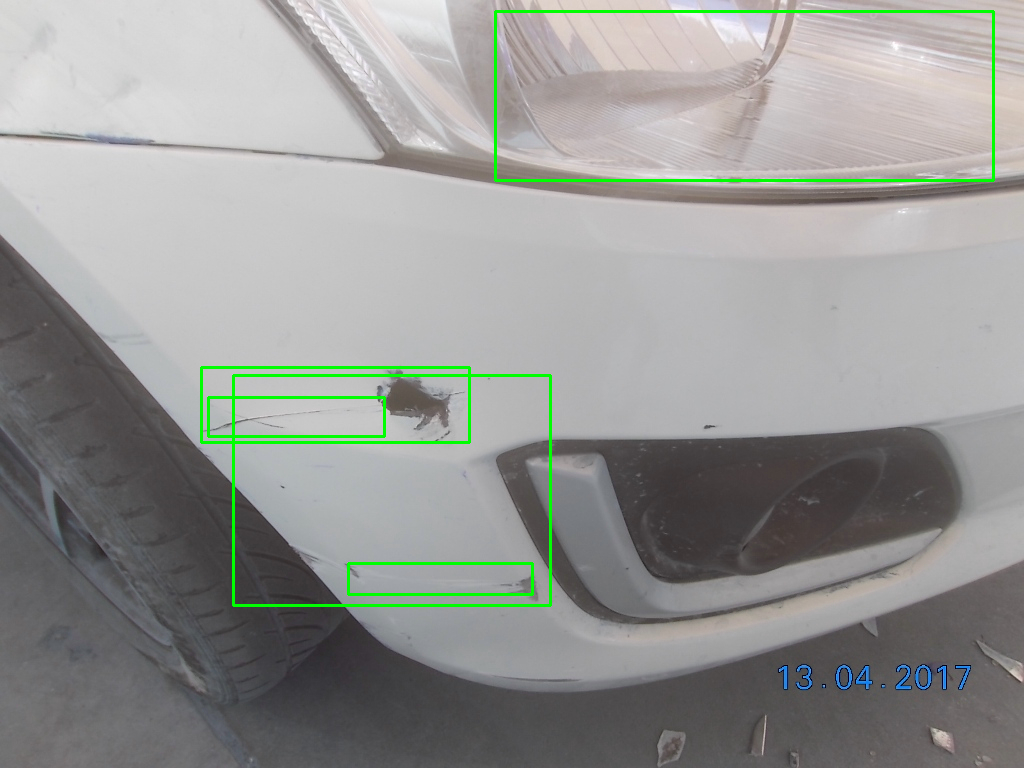

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Convert the test image to a NumPy array
test_image_np = np.array(test_image)

# Draw bounding boxes on the image
for box in filtered_boxes:
    box = box.detach().cpu().numpy().astype(int)
    cv2.rectangle(test_image_np, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)  # Green bounding box

# Display the image with detected scratches
cv2_imshow(test_image_np)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [ ]:
from google.colab import files
import matplotlib.pyplot as plt

# Assuming 'image' is the variable containing your image data
# Replace 'image.png' with your image name if necessary
plt.imsave('image.png', test_image_np)

# Download the image to your local machine
files.download('image.png')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>